## Imports

In [1]:
seed = 17
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from scipy import stats
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import seaborn as sns
import pickle

# Main

### LOAD DATA

In [2]:
# LOAD DATA
# Lists of observations and targets
Xs = []
ys = []

Xs.append(pd.read_csv("../data/credit_X.csv"))
Xs.append(pd.read_csv("../data/raisin_X.csv"))
Xs.append(pd.read_csv("../data/alzheimer_X.csv"))
Xs.append(pd.read_csv("../data/salary_X.csv"))

ys.append(pd.read_csv("../data/credit_y.csv").iloc[:, 0])
ys.append(pd.read_csv("../data/raisin_y.csv").iloc[:, 0])
ys.append(pd.read_csv("../data/alzheimer_y.csv").iloc[:, 0])
ys.append(pd.read_csv("../data/salary_y.csv").iloc[:, 0])

## Functions

In [3]:
def tune_with_random_search(model, search_grid, n_iter, scoring):
    opt_results = []
    for i in range(4):
        # in my case works faster with n_jobs=-1
        opt = RandomizedSearchCV(model, search_grid, n_iter=n_iter, cv=5, scoring=scoring, random_state=seed, n_jobs=-1)
        opt_results.append(opt.fit(Xs[i], ys[i]))
    return opt_results
    
def tune_with_bayes_search(model, search_grid, n_iter, scoring):
    opt_results = []
    for i in range(4):
        opt = BayesSearchCV(model, search_grid, n_iter=n_iter, cv=5, scoring=scoring, random_state=seed)
        opt_results.append(opt.fit(Xs[i], ys[i]))
    return opt_results

def get_tunability(model_class, default_grid, tuned_grids, scoring):
    tunabilities = []
    for i in range(4):
        default_score = cross_val_score(model_class(**default_grid), Xs[i], ys[i], cv=5, scoring=scoring, n_jobs=-1).mean()
        tuned_score = cross_val_score(model_class(**tuned_grids[i].best_params_), Xs[i], ys[i], cv=5, scoring=scoring, n_jobs=-1).mean()
        tunabilities.append(tuned_score - default_score)
    return tunabilities

def save_result(result, path_to_save):
    with open(path_to_save, 'wb') as file:
        pickle.dump(result, file)

def load_result(path):
    with open(path, 'rb') as file:
        return pickle.load(file)

## Logistic Regression
For now just to see how long it will work etc..

### Algorithm tunability

#### RandomSearch

In [4]:
# More possibilities of these parameters are possible but idk how to manage an exception when one parameter works only when another is set to some value
# For example when penalty equals elasticnet there must be specified l1_ratio which isn't possible to define if other options of penalty are set
# Then a solution is needed but for now I won't think about it
search_grid = {
    'C': stats.loguniform(1e-4, 1e4),
    'penalty': ['l1', 'l2'],            
    'solver': ['liblinear', 'saga'],
    "class_weight": [None, "balanced"],
    "max_iter": [10000],
    "random_state": [seed]
}

In [5]:
%%time
# Tuning using randomsearch
lr_opt_results_rs = tune_with_random_search(LogisticRegression(), search_grid, 100, "roc_auc")

CPU times: total: 5.59 s
Wall time: 6min 19s


In [6]:
# Save tuning
save_result(lr_opt_results_rs, "./saved_results/lr_opt_results_rs.pkl")

In [7]:
# Best params:
for i in range(4):
    print(lr_opt_results_rs[i].best_params_)

{'C': 4.653728536831328, 'class_weight': None, 'max_iter': 10000, 'penalty': 'l1', 'random_state': 17, 'solver': 'liblinear'}
{'C': 0.02276774514949344, 'class_weight': 'balanced', 'max_iter': 10000, 'penalty': 'l1', 'random_state': 17, 'solver': 'liblinear'}
{'C': 1.0426363365116773, 'class_weight': None, 'max_iter': 10000, 'penalty': 'l1', 'random_state': 17, 'solver': 'liblinear'}
{'C': 1.5673785765477308, 'class_weight': 'balanced', 'max_iter': 10000, 'penalty': 'l1', 'random_state': 17, 'solver': 'liblinear'}


In [8]:
# Tunabilities scores on diffrent datasets
lr_tunabilities_rs = get_tunability(LogisticRegression, {"random_state": seed, "max_iter": 10000}, lr_opt_results_rs, "roc_auc")
lr_tunabilities_rs

[0.038273458997143184,
 0.0009135802469134591,
 0.0006813720598669581,
 0.0024515120410580904]

#### BayesSearch

In [9]:
search_grid = {
    'C': Real(1e-4, 1e4, prior='log-uniform'),
    'penalty': Categorical(['l1', 'l2']),            
    'solver': Categorical(['liblinear', 'saga']),
    "class_weight": Categorical([None, "balanced"]),
    "max_iter": Categorical([10000]),
    "random_state": Categorical([seed])
}

In [10]:
# Much more time than in randomized version

In [11]:
%%time
# Tuning using bayessearch
lr_opt_results_bs = tune_with_bayes_search(LogisticRegression(), search_grid, 100, "roc_auc")

CPU times: total: 25min 24s
Wall time: 24min 16s


In [12]:
# Save results
save_result(lr_opt_results_bs, "./saved_results/lr_opt_results_bs.pkl")

In [13]:
# Best params:
for i in range(4):
    print(lr_opt_results_bs[i].best_params_)

OrderedDict({'C': 2.199629428788965, 'class_weight': None, 'max_iter': 10000, 'penalty': 'l1', 'random_state': 17, 'solver': 'liblinear'})
OrderedDict({'C': 0.20446408844275932, 'class_weight': None, 'max_iter': 10000, 'penalty': 'l1', 'random_state': 17, 'solver': 'liblinear'})
OrderedDict({'C': 0.3324395694591504, 'class_weight': 'balanced', 'max_iter': 10000, 'penalty': 'l1', 'random_state': 17, 'solver': 'liblinear'})
OrderedDict({'C': 3.259386726069581, 'class_weight': 'balanced', 'max_iter': 10000, 'penalty': 'l1', 'random_state': 17, 'solver': 'liblinear'})


In [14]:
# Tunabilities scores on diffrent datasets
lr_tunabilities_bs = get_tunability(LogisticRegression, {"random_state": seed, "max_iter": 10000}, lr_opt_results_bs, "roc_auc")
lr_tunabilities_bs

[0.04111028773857739,
 0.0015061728395062701,
 0.0008687976466631442,
 0.003187756283721477]

#### Plots

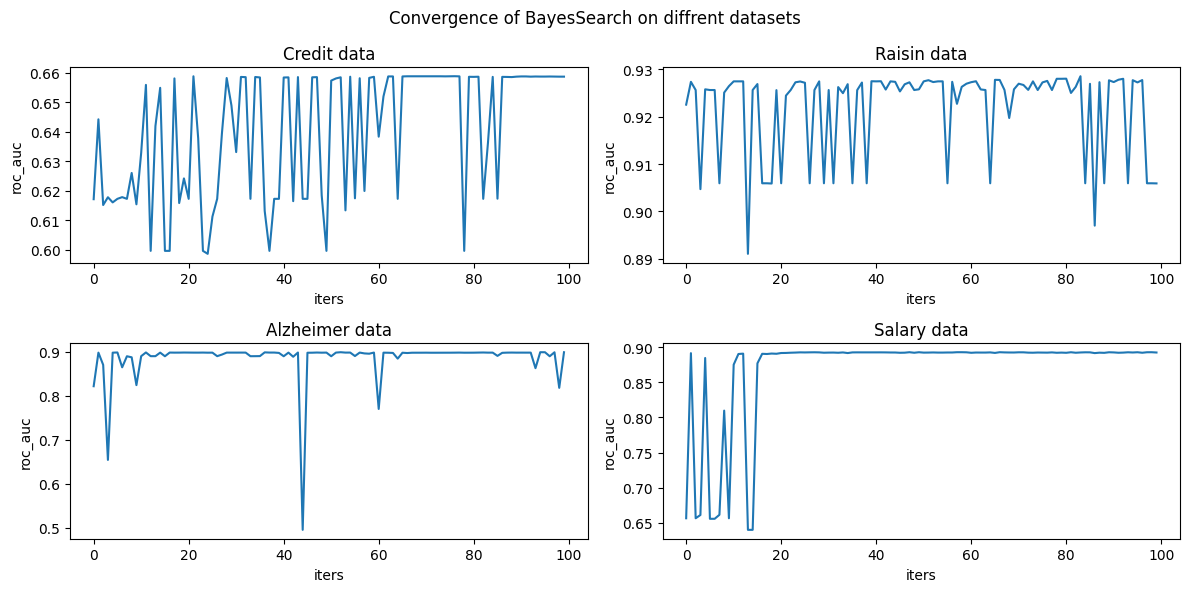

In [15]:
titles = ["Credit data", "Raisin data", "Alzheimer data", "Salary data"]
fig, axs = plt.subplots(2, 2, figsize = (12, 6))
axs = axs.flatten()
fig.suptitle("Convergence of BayesSearch on diffrent datasets")
for i in range(4):
    axs[i].plot(lr_opt_results_bs[i].cv_results_["mean_test_score"])
    axs[i].set_title(titles[i])
    axs[i].set_xlabel("iters")
    axs[i].set_ylabel("roc_auc")
plt.tight_layout()
plt.show()

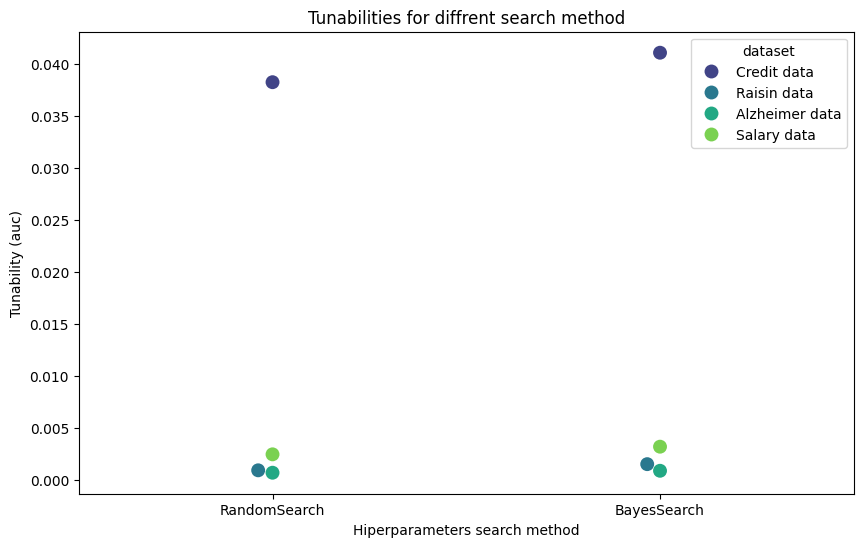

In [16]:
data = {
    'tunability': lr_tunabilities_rs + lr_tunabilities_bs,
    'alg': ["RandomSearch"] *  4 + ["BayesSearch"] * 4,
    'dataset': ["Credit data", "Raisin data", "Alzheimer data", "Salary data"]*2
}
df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
sns.swarmplot(x='alg', y='tunability', hue='dataset', data=df, palette='viridis', size=10)

plt.title('Tunabilities for diffrent search method')
plt.xlabel('Hiperparameters search method')
plt.ylabel('Tunability (auc)')
plt.show()

In [18]:
# Bcs lr has only one important parameter to tune ("C") by analizing whole algorithm tunability there is also analized tunability of "C" 
#hence i wont do hyperparameter tuning again.